# Machine Learning Pipeline - Data Analysis

Implementation of each of the steps in the Machine Learning Pipeline. 

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

Plane Crash Dataset available on [Kaggle.com](https://www.kaggle.com/datasets/kamilkarczmarczyk/plane-crash-dataset-03042023). See below for more details.

===================================================================================================

Data description:
- Date: Date of accident, in the format - January 01, 2001
- Time: Local time, in 24 hr. format unless otherwise specified
- Airline/Op: Airline or operator of the aircraft
- Flight #: Flight number assigned by the aircraft operator
- Route: Complete or partial route flown prior to the accident
- AC Type: Aircraft type
- Reg: ICAO registration of the aircraft
- cn / ln: Construction or serial number / Line or fuselage number
- Aboard: Total aboard (passengers / crew)
- Fatalities: Total fatalities aboard (passengers / crew)
- Ground: Total killed on the ground
- Summary: Brief description of the accident and cause if known

# Data Analysis

In [1]:
# ! python -m spacy download en_core_web_sm
# ! pip install pytest
# ! pip install ipytest
# ! pip install varname

In [2]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime as dt
import re
from varname import nameof

import pytest
import ipytest
ipytest.autoconfig()

from datetime import date as date_, time as time_
from pydantic import BaseModel, Field
from typing import List
import pandera as pa
from pandera.typing import DataFrame, Series
import pydantic
from typing import Optional

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import spacy
import gensim
from typing import Union
import logging
import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import spacy.cli
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict

%matplotlib inline

In [3]:
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
logging.getLogger().setLevel(logging.INFO)
# logging.info(f"\033[033m***TEST***: {data.shape=}\033[0m") 

In [5]:
# load dataset
raw_data = pd.read_csv("data/raw_data.csv", sep=";")

# rows and columns of the data
logging.info(f"\033[36m {raw_data.shape=}\033[0m")

# visualise the dataset
raw_data.head()

INFO:root: raw_data.shape=(5028, 17)


,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:
0,18.03.1946,NaN,"Between Chungking and Shanghai, China",NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,?,?,?,?,NaN,139,Disappeared while en route. Plane never located.
1,09.11.1944,NaN,"Seljord, Norway",NaN,Military - U.S. Army Air Corps,NaN,NaN,NaN,Yes,U.S. Army Air Corps,?,?,?,?,NaN,42-52196,NaN
2,09.05.1989,NaN,"Near Tainjin, China",Bell 412,Aero Asahi,NaN,33070,NaN,No,NaN,?,?,10,?,0.0000,JA9596,NaN
3,20.02.1992,NaN,En route from Argentina to California,Boeing B-747,Aerolineas Argentinas,NaN,NaN,386,No,NaN,?,?,1,?,0.0000,NaN,A passenger died of cholera while en route.
4,13.03.1954,NaN,"Dien Bien Phu, South Vietnam",C-46,Aigle Azur,NaN,NaN,NaN,No,NaN,?,?,?,?,NaN,NaN,Shot down.


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   5028 non-null   object 
 1   Time:                  3482 non-null   object 
 2   Location:              5023 non-null   object 
 3   AC        Type:        5014 non-null   object 
 4   Operator:              5018 non-null   object 
 5   Route:                 4264 non-null   object 
 6   cn / ln:               4358 non-null   object 
 7   Flight #:              1338 non-null   object 
 8   Is_military            5018 non-null   object 
 9   Military country       766 non-null    object 
 10  Aboard_all             5028 non-null   object 
 11  Aboard_passengers      5028 non-null   object 
 12  Fatalities_all         5028 non-null   object 
 13  Fatalities_passengers  5028 non-null   object 
 14  Ground:                4984 non-null   float64
 15  Regi

In [7]:
# make a copy of original data to work with
data = raw_data.copy()

In [8]:
# rename columns
multiple_white_spaces = re.compile(r"\s+")
data.columns = [multiple_white_spaces.sub("_", _) for _ in (re.sub(r"[:/]", "", c) for c in data.columns)]

logging.info(f"\033[36m {data.columns=}\033[0m")

INFO:root: data.columns=Index(['Date', 'Time', 'Location', 'AC_Type', 'Operator', 'Route', 'cn_ln',
       'Flight_#', 'Is_military', 'Military_country', 'Aboard_all',
       'Aboard_passengers', 'Fatalities_all', 'Fatalities_passengers',
       'Ground', 'Registration', 'Summary'],
      dtype='object')


# Data schemas

In [9]:
class DataSchemaValidation(BaseModel):
    date: date_ = Field(alias="Date")
    time: time_ = Field(alias="Time")
    location: str = Field(alias="Location")
    ac_type: str = Field(alias="AC_Type")
    operator: str = Field(alias="Operator")
    route: str = Field(alias="Route")
    cn_ln: str = Field(alias="cn_ln")
    flight_n: str = Field(alias="Flight_#")
    is_military: str = Field(alias="Is_military")
    mlitary_country: str = Field(alias="Military_country")
    aboard_all: int = Field(alias="Aboard_all")
    aboard_passengers: int = Field(alias="Aboard_passengers")
    fatalities_all: int = Field(alias="Fatalities_all")
    fatalities_passengers: int = Field(alias="Fatalities_passengers")
    ground: int = Field(alias="Ground")
    registration: str = Field(alias="Registration")
    summary: str = Field(alias="Summary")
    year: Optional[int] = Field(alias="Year")
    month: Optional[int] = Field(alias="Month")
    hour: Optional[int] = Field(alias="Hour")
    routes_n: Optional[int] = Field(alias="Routes_#")
    vector: Optional[list] = Field(alias="Vector")
    fatalities: Optional[int] = Field(alias="Fatalities")
    survived: Optional[int] = Field(alias="Survived")
    survived_pct: Optional[float] = Field(alias="Survived_pct")


class DataSchema:
    date = "Date"
    time = "Time"
    location = "Location"
    ac_type = "AC_Type"
    operator = "Operator"
    route = "Route"
    cn_ln = "cn_ln"
    flight_n = "Flight_#"
    is_military = "Is_military"
    mlitary_country = "Military_country"
    aboard_all = "Aboard_all"
    aboard_passengers = "Aboard_passengers"
    fatalities_all = "Fatalities_all"
    fatalities_passengers = "Fatalities_passengers"
    ground = "Ground"
    registration = "Registration"
    summary = "Summary"
    routes_lst = "Routes_lst"
    year = "Year"
    month = "Month"
    hour = "Hour"
    routes_n = "Routes_#"
    vector = "Vector"
    fatalities = "Fatalities"
    survived = "Survived"
    survived_pct = "Survived_pct"

## Missing values/ Unique values

In [10]:
# list of columns to drop after EDA
redundant_columns = []

# replace missing values in form of "?"
data = data.replace("?", np.nan)

In [11]:
def get_pct_missing_and_unique(col: str) -> None:
    logging.info(f"\033[33m{col}\033[0m field has \033[36m{data[col].isna().sum()/data.shape[0]:.2%}\033[0m missing values")
    logging.info(f"\033[33m{col}\033[0m field has \033[32m{data[col].nunique()/data.shape[0]:.2%}\033[0m unique values\n")

In [12]:
for col in data.columns:
    get_pct_missing_and_unique(col)

INFO:root:Date field has 0.00% missing values
INFO:root:Date field has 91.41% unique values

INFO:root:Time field has 30.75% missing values
INFO:root:Time field has 21.16% unique values

INFO:root:Location field has 0.10% missing values
INFO:root:Location field has 82.30% unique values

INFO:root:AC_Type field has 0.28% missing values
INFO:root:AC_Type field has 48.19% unique values

INFO:root:Operator field has 0.20% missing values
INFO:root:Operator field has 45.07% unique values

INFO:root:Route field has 15.19% missing values
INFO:root:Route field has 76.55% unique values

INFO:root:cn_ln field has 13.33% missing values
INFO:root:cn_ln field has 78.02% unique values

INFO:root:Flight_# field has 73.39% missing values
INFO:root:Flight_# field has 17.96% unique values

INFO:root:Is_military field has 0.20% missing values
INFO:root:Is_military field has 0.04% unique values

INFO:root:Military_country field has 84.77% missing values
INFO:root:Military_country field has 4.26% unique val

In [13]:
# plot columns in discending order of percent unique for columns with more then 1 unique values
def plot_pct_unique(data: DataFrame) -> None:
    df = data.copy()
    # make a list of the variables that contain unique values
    vars_with_unique = [var for var in df.columns if df[var].nunique()/data.shape[0] > 0]

    # determine percentage of unique values (expressed as decimals)
    # and display the result ordered by % of unique data
    table = df[vars_with_unique].nunique().sort_values(ascending=False)/df.shape[0]
    print(table)
    
    # plot
    table.plot.bar(figsize=(10, 4))
    plt.ylabel('Percentage of unique data')
    plt.axhline(y=0.80, color='r', linestyle='-')
    plt.axhline(y=0.15, color='g', linestyle='-')

    plt.show()


# plot columns with missing values in discending order of percent missing
def plot_pct_missing(data: DataFrame) -> None:
    df = data.copy()
    # make a list of the variables that contain missing values
    vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

    # determine percentage of missing values (expressed as decimals)
    # and display the result ordered by % of missin data
    print(df[vars_with_na].isnull().mean().sort_values(ascending=False))
    
    # plot
    df[vars_with_na].isnull().mean().sort_values(
        ascending=False).plot.bar(figsize=(10, 4))
    plt.ylabel('Percentage of missing data')
    plt.axhline(y=0.80, color='r', linestyle='-')
    plt.axhline(y=0.15, color='g', linestyle='-')

    plt.show()

Military_country        0.8477
Flight_#                0.7339
Time                    0.3075
Route                   0.1519
cn_ln                   0.1333
Registration            0.0547
Fatalities_passengers   0.0467
Aboard_passengers       0.0440
Summary                 0.0117
Ground                  0.0088
Aboard_all              0.0034
AC_Type                 0.0028
Operator                0.0020
Is_military             0.0020
Fatalities_all          0.0016
Location                0.0010
dtype: float64


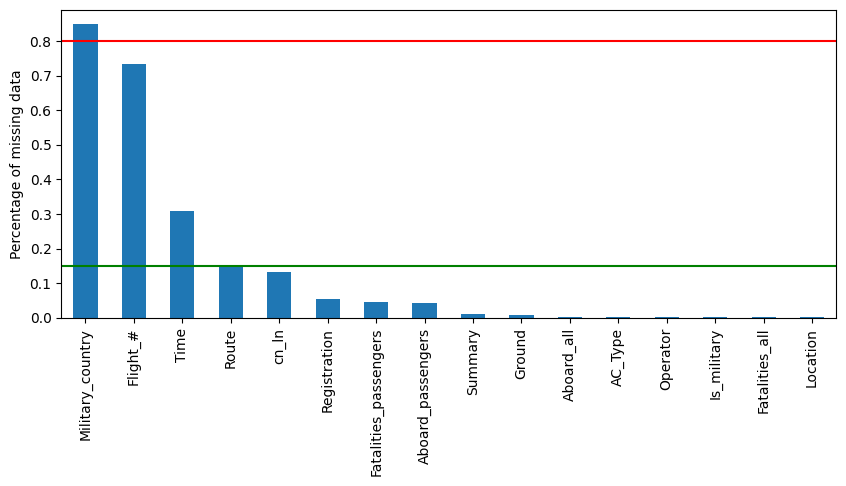

In [14]:
plot_pct_missing(data)

Summary                 0.9696
Registration            0.9381
Date                    0.9141
Location                0.8230
cn_ln                   0.7802
Route                   0.7655
AC_Type                 0.4819
Operator                0.4507
Time                    0.2116
Flight_#                0.1796
Aboard_all              0.0485
Aboard_passengers       0.0465
Military_country        0.0426
Fatalities_all          0.0396
Fatalities_passengers   0.0378
Ground                  0.0099
Is_military             0.0004
dtype: float64


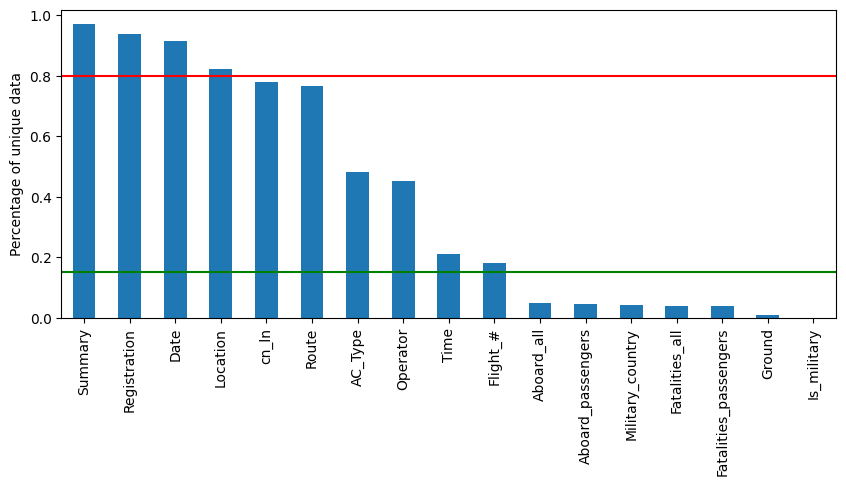

In [15]:
plot_pct_unique(data)

In [16]:
redundant_columns.extend([DataSchema.mlitary_country, DataSchema.flight_n, DataSchema.time])

# Drop samples that has missing values in columns

In [17]:
test = data.copy()
vars_with_na = [var for var in data.columns if data[var].isnull().sum()/data.shape[0] < 0.15]
test.dropna(subset=vars_with_na, inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{test.shape=}\033[0m")
logging.info(f"test dataset reduced by \033[35m{1-test.shape[0]/raw_data.shape[0]:.2%}\033[0m\
 dropping samples w/ nan in columns w/ \033[35mmssings values under 15%\033[0m")
test = data.copy()
vars_with_na = [var for var in data.columns if data[var].isnull().sum()/data.shape[0] < 0.05]
test.dropna(subset=vars_with_na, inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{test.shape=}\033[0m")
logging.info(f"test dataset reduced by \033[35m{1-test.shape[0]/raw_data.shape[0]:.2%}\033[0m\
 dropping samples w/ nan in columns w/ \033[35mmssings values under 5%\033[0m")

data.dropna(subset=[DataSchema.summary], inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{data.shape=}\033[0m")
logging.info(f"dataset reduced by \033[32m{1-data.shape[0]/raw_data.shape[0]:.2%}\033[0m\
 dropping samples with missing \033[32msummary\033[0m")

INFO:root:raw_data.shape=(5028, 17)
          test.shape=(4222, 17)
INFO:root:test dataset reduced by 16.03% dropping samples w/ nan in columns w/ mssings values under 15%
INFO:root:raw_data.shape=(5028, 17)
          test.shape=(4723, 17)
INFO:root:test dataset reduced by 6.07% dropping samples w/ nan in columns w/ mssings values under 5%
INFO:root:raw_data.shape=(5028, 17)
          data.shape=(4969, 17)
INFO:root:dataset reduced by 1.17% dropping samples with missing summary


# Route

In [18]:
get_pct_missing_and_unique(DataSchema.route)

INFO:root:Route field has 14.41% missing values
INFO:root:Route field has 77.26% unique values



In [19]:
data[DataSchema.route].sample(5)

3288       Tokyo - Honolulu
3031    Tachilek - Mandalay
4210        Berlin - Munich
4000        Varsovie-Slupsk
2386                    NaN
Name: Route, dtype: object

In [20]:
# get number of routes(airports)
def get_multiple_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    route = text.split(" - ")    
    for point in route:
        doc = nlp(point)
        for ent in doc.ents:
            if ent.label_=="GPE":
                point = ent.text
    flatten = list(itertools.chain(*[[j] if isinstance(j, str) else j for j in [i.split(", ") for i in route]]))
    return flatten

In [21]:
%%ipytest -qq

# TEST

input_output = [
    ("Sukhumi - Kutaisi", ["Sukhumi", "Kutaisi"]), 
    ("Test flight", ["Test flight"]),
    (np.nan, np.nan), 
    ("Bombing run", ["Bombing run"]), 
    ("Kaboul-Kunduz", ["Kaboul", "Kunduz"]),
    ("Burbank,- St. Paul", ["Burbank", "St. Paul"]),
    ("Boston - NY - Washington DC - Jacksonville - Miami", ["Boston", "NY", "Washington DC", "Jacksonville", "Miami"]),
    ("Lima - Pucallpa - Iquitos", ["Lima", "Pucallpa", "Iquitos"])
]


@pytest.mark.nondestructive
@pytest.mark.parametrize("item,expected",input_output)
def test_get_multiple_locations(item, expected):
    output = get_multiple_locations(item)
    assert output in [expected], f"Expected output is {expected}, got: {output}"

....FF..                                                                                     [100%]
============================================= FAILURES =============================================
_______________________ test_get_multiple_locations[Kaboul-Kunduz-expected4] _______________________

item = 'Kaboul-Kunduz', expected = ['Kaboul', 'Kunduz']

    @pytest.mark.nondestructive
    @pytest.mark.parametrize("item,expected",input_output)
    def test_get_multiple_locations(item, expected):
        output = get_multiple_locations(item)
>       assert output in [expected], f"Expected output is {expected}, got: {output}"
E       AssertionError: Expected output is ['Kaboul', 'Kunduz'], got: ['Kaboul-Kunduz']
E       assert ['Kaboul-Kunduz'] in [['Kaboul', 'Kunduz']]

/var/folders/24/kzw5nvd15h3_0w6x7c40l6t00000gq/T/ipykernel_12122/420097867.py:19: AssertionError
____________________ test_get_multiple_locations[Burbank,- St. Paul-expected5] _____________________

item = 'Burbank,- 

In [22]:
# replace Route free text value with list of destinations per flight
data[DataSchema.routes_lst] = data[DataSchema.route].apply(lambda x: get_multiple_locations(x))

In [23]:
# create new column derived from Route and represented number of routes per flight
data[DataSchema.routes_n] = data[DataSchema.routes_lst].apply(lambda x: 0 if x is np.nan else len(x))

In [24]:
data[DataSchema.routes_n].value_counts()

Routes_#
2    2905
0     716
4     452
3     441
1     369
5      59
6      26
7       1
Name: count, dtype: int64

In [25]:
data[data[DataSchema.routes_n] == 1].sample(5)

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#
4525,08.03.2007,15:00:00,"Princeville, Hawaii",Aerospatiale AS350BA Rotocraft,Heli-USA Airways,Sightseeing,1168,NaN,No,NaN,7,6,4,3,0.0000,N354NT,The helicopter crashed on Kauai shortly after ...,[Sightseeing],1
3808,12.12.1956,09:00:00,"Dannemois, France",Vickers 708 Viscount,Air France,Training,8,NaN,No,NaN,5,0,5,0,0.0000,F-BGNK,Crashed in a steep angle of attack.,[Training],1
220,26.03.1979,NaN,"Luanda, Angola",Ilyushin IL-18D,Interflug,Luanda-Berlin,186009402,NaN,No,NaN,10,6,10,6,0.0000,DM-STL,The cargo plane lost the No. 2 engine on takeo...,[Luanda-Berlin],1
1874,21.11.1933,15:00:00,"Near Kharkov, Ukraine, USSR",Kalinin K-7,Kalinin,Test flight,NaN,NaN,No,NaN,20,0,14,0,0.0000,NaN,Crashed due to structural failure during a tes...,[Test flight],1
787,18.12.1981,13:06:00,"Near Covenas, Colombia",de Havilland Canada DHC-6 Twin Otter 300,ACES Colombia,Medellin-Monteria-Covenas,609,NaN,No,NaN,13,11,13,11,0.0000,HK-2217,Struck high ground.,[Medellin-Monteria-Covenas],1


In [26]:
redundant_columns.append(DataSchema.route)

## Date: extract year and month

In [27]:
get_pct_missing_and_unique(DataSchema.date)

INFO:root:Date field has 0.00% missing values
INFO:root:Date field has 91.47% unique values



In [28]:
# extract year and month from date into separate columns
data[DataSchema.year] = pd.to_datetime(data[DataSchema.date]).dt.year
data[DataSchema.month] = pd.to_datetime(data[DataSchema.date]).dt.month
redundant_columns.append(DataSchema.date)

In [29]:
for col in [DataSchema.year, DataSchema.month]:
    get_pct_missing_and_unique(col)

INFO:root:Year field has 0.00% missing values
INFO:root:Year field has 2.27% unique values

INFO:root:Month field has 0.00% missing values
INFO:root:Month field has 0.24% unique values



## Location: extract state

In [30]:
get_pct_missing_and_unique(DataSchema.location)

INFO:root:Location field has 0.10% missing values
INFO:root:Location field has 82.29% unique values



In [31]:
data[DataSchema.location].sample(5)

3399               Asuncion, Paraguay
163     Campbeltown, Argyll, Scotland
3268              Near Silchar, India
1647                Thies, Mauritania
477               Near Jima, Ethiopia
Name: Location, dtype: object

In [32]:
def get_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    locations = [] 
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            locations.append(ent.text)
    return locations[-1] if locations else text

In [33]:
%%ipytest -qq

# TEST

input_output = [("Between Chungking and Shanghai, China", "China")]


@pytest.mark.nondestructive
@pytest.mark.parametrize("item,expected",input_output)
def test_get_locations(item, expected):
    output = get_locations(item)
    assert output in [expected], f"Expected output is {expected}, got: {output}"

.                                                                                            [100%]
========================================= warnings summary =========================================
../../../.pyenv/versions/3.11.0/envs/deploing_ml_models/lib/python3.11/site-packages/_pytest/config/__init__.py:1204
  /Users/Viktoryia.Kisialeuskaya/.pyenv/versions/3.11.0/envs/deploing_ml_models/lib/python3.11/site-packages/_pytest/config/__init__.py:1204: PytestAssertRewriteWarning: Module already imported so cannot be rewritten: typeguard
    self._mark_plugins_for_rewrite(hook)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


In [34]:
data[DataSchema.location] = data[DataSchema.location].apply(lambda x: get_locations(x))
data[DataSchema.location]

0                              China
3                         California
4       Dien Bien Phu, South Vietnam
6                              China
8                     North Carolina
                    ...             
5023                    Saudi Arabia
5024                        Oklahoma
5025                      Kazakhstan
5026                        Pakistan
5027                         Ireland
Name: Location, Length: 4969, dtype: object

In [35]:
print(f"Location field after parsing for country has \033[31m{data[DataSchema.location].nunique()/data.shape[0]:.2%}\033[0m unique values")

Location field after parsing for country has 10.06% unique values


## AC Type: check for missing values

In [36]:
get_pct_missing_and_unique(DataSchema.ac_type)

INFO:root:AC_Type field has 0.22% missing values
INFO:root:AC_Type field has 48.38% unique values



In [37]:
data[DataSchema.ac_type]

0                                      NaN
3                             Boeing B-747
4                                     C-46
6                             Douglas C-47
8                             Douglas DC-3
                       ...                
5023                       Lockheed C-130H
5024                 Lockheed 188C Electra
5025                            Fokker 100
5026                       Airbus A320-214
5027    Lockheed 1049H Super Constellation
Name: AC_Type, Length: 4969, dtype: object

In [38]:
data[data[DataSchema.ac_type].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Month
0,18.03.1946,NaN,China,NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,139,Disappeared while en route. Plane never located.,"[Chunking, Shanghai]",2,1946,3
22,08.11.1943,NaN,India,NaN,Military - Indian Air Force,NaN,NaN,NaN,Yes,Indian Air Force,1,NaN,1,NaN,37.0000,NaN,Crashed into a village.,NaN,0,1943,11
1284,08.04.1922,NaN,China,NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...,[Test],1,1922,4
1616,29.06.1945,NaN,India,NaN,Military - Royal Indian Air Force,NaN,NaN,NaN,Yes,Royal Indian Air Force,2,NaN,2,NaN,36.0000,NaN,Crashed into a village exploding and destoying...,NaN,0,1945,6
1623,08.08.1951,21:00:00,Australia,NaN,Trans Australia Airlines,Hobart Melbourne,13083,NaN,No,NaN,2,0,2,0,0.0000,VH-TAT,Cargo plane. Loss of lateral control during a ...,[Hobart Melbourne],1,1951,8
1862,17.03.1946,NaN,China,NaN,Military - Chinese Air Force,Shanghai - Nanking,NaN,NaN,Yes,Chinese Air Force,20,NaN,20,NaN,0.0000,NaN,Crashed into mountainous terrain in low visibi...,"[Shanghai, Nanking]",2,1946,3
1863,11.02.1996,NaN,Afghanistan,NaN,Military - Taliban Militia,NaN,NaN,NaN,Yes,Taliban Militia,20,NaN,20,NaN,0.0000,NaN,The helicopter was shot down.,NaN,0,1996,2
2625,22.11.1961,NaN,Zimbabwe,NaN,Rhodesian Air Services,Salisbury - Livingstone - Elizabethville,19351,NaN,No,NaN,3,0,3,0,0.0000,VP-YRX,The aircraft was on a charter flight to Living...,"[Salisbury, Livingstone, Elizabethville]",3,1961,11
3451,15.07.1967,NaN,Canada,NaN,Eastern Provincial Airways,NaN,NaN,NaN,No,NaN,4,3,4,3,0.0000,NaN,Crashed minutes after takeoff.,NaN,0,1967,7
4551,26.03.1952,NaN,Russia,NaN,Aeroflot,NaN,NaN,NaN,No,NaN,70,NaN,70,NaN,0.0000,NaN,The plane overshot the runway and collided wit...,NaN,0,1952,3


In [39]:
# TODO group Aircraft types

## ~~Operator~~

In [40]:
get_pct_missing_and_unique(DataSchema.operator)

INFO:root:Operator field has 0.18% missing values
INFO:root:Operator field has 45.26% unique values



In [41]:
data[DataSchema.operator]

0       China National Aviation Corporation
3                     Aerolineas Argentinas
4                                Aigle Azur
6       China National Aviation Corporation
8                                  Piedmont
                       ...                 
5023       Military - Royal Saudi Air Force
5024                American Flyers Airline
5025                                Bek Air
5026         Pakistan International Airline
5027               KLM Royal Dutch Airlines
Name: Operator, Length: 4969, dtype: object

In [42]:
data[data[DataSchema.operator].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Month
158,07.09.1909,NaN,France,Wright Byplane,NaN,Air show,NaN,NaN,NaN,NaN,1,0,1,0,0.0000,SC1,Eugene Lefebvre was the first pilot to ever be...,[Air show],1,1909,9
728,04.07.1943,23:00:00,Gibraltar,Consolidated Liberator B24 C,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,12,NaN,0.0000,A-L-523,"The flight, bound for London, crashed into the...",NaN,0,1943,7
1145,17.06.1917,NaN,England,Zepplin L-48 (air ship),NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,14,NaN,0.0000,L-48,Shot down by aircraft.,NaN,0,1917,6
1189,02.09.1963,NaN,Northeast Laos,Curtiss C-46 Commando,NaN,NaN,NaN,NaN,NaN,NaN,16,13,15,12,NaN,NaN,Refugee flight.,NaN,0,1963,9
1284,08.04.1922,NaN,China,NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...,[Test],1,1922,4
2847,26.12.2011,05:54:00,Florida,Bell 206B,NaN,"Jacksonville, FL - Gainsville, FL",2636,NaN,NaN,NaN,3,2,3,2,0.0000,N5016M,The on-demand air taxi was on a flight to proc...,"[Jacksonville, FL, Gainsville, FL]",4,2011,12
2892,04.07.1922,NaN,Germany,LVG C VI,NaN,Hamburg - Berlin,NaN,NaN,NaN,NaN,3,2,2,1,0.0000,NaN,The passenger/mail plane lost it's engine whil...,"[Hamburg, Berlin]",2,1922,7
3932,26.09.1926,NaN,New York,Sikorsky S-25,NaN,New York - Paris,NaN,NaN,NaN,NaN,5,4,2,2,0.0000,NaN,Too much weight caused the landing gear to col...,"[New York, Paris]",2,1926,9
4847,29.05.1935,NaN,Honduras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,6,NaN,0.0000,NaN,Crashed into the Ulua River.,NaN,0,1935,5


In [43]:
def get_operators(text: str) -> Union[None, list]:
    if text is np.nan:
        return text
    if "test" in text.lower():
        return text
    operators = []
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            operators.append(ent.text)
    return operators[-1] if operators else text

In [44]:
%%ipytest -qq

# TEST

input_output = [
    (np.nan, np.nan),
    ("Military - U.S. Army Air Corps", "U.S. Army Air Corps"),
    ("Test", "Test"),
    ("American Flyers Airline", "American Flyers Airline"),
    ("KLM Royal Dutch Airlines", "KLM Royal Dutch Airlines"),
    ("Air Canada", "Air Canada")
]


@pytest.mark.nondestructive
@pytest.mark.parametrize("item,expected",input_output)
def test_get_operators(item, expected):
    output = get_operators(item)
    assert output in [expected], f"Expected output is {expected}, got: {output}"

.F....                                                                                       [100%]
============================================= FAILURES =============================================
______________ test_get_operators[Military - U.S. Army Air Corps-U.S. Army Air Corps] ______________

item = 'Military - U.S. Army Air Corps', expected = 'U.S. Army Air Corps'

    @pytest.mark.nondestructive
    @pytest.mark.parametrize("item,expected",input_output)
    def test_get_operators(item, expected):
        output = get_operators(item)
>       assert output in [expected], f"Expected output is {expected}, got: {output}"
E       AssertionError: Expected output is U.S. Army Air Corps, got: Military - U.S. Army Air Corps
E       assert 'Military - U.S. Army Air Corps' in ['U.S. Army Air Corps']

/var/folders/24/kzw5nvd15h3_0w6x7c40l6t00000gq/T/ipykernel_12122/1874726575.py:17: AssertionError
========================================= warnings summary ================================

In [45]:
tmp = data.copy()
tmp["tmp"] = tmp[DataSchema.operator].apply(lambda x: get_operators(x))

In [46]:
tmp[tmp[DataSchema.operator]!=tmp["tmp"]].sample(5)

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Month,tmp
956,30.11.1988,07:20:00,Libya,de Havilland Canada DHC-6 Twin Otter 300,Aero Club Libya,Hamada al Hambra - Tripoli,670,NaN,No,NaN,14,12,14,12,0.0000,5A-DDD,While attempting to land in mist and poor visi...,"[Hamada al Hambra, Tripoli]",2,1988,11,Aero Club
993,22.11.1994,22:03:00,Missouri,McDonnell Douglas DC-9-82 / Cessna 441,Trans World Airlines / Private,NaN,49426 / 0196,NaN,No,NaN,142,132,2,0,0.0000,N954U/N411KM,"During its takeoff roll, the DC-9 collided wit...",NaN,0,1994,11,Trans World Airlines
1476,16.04.1972,22:10:00,Italy,Fokker F-27 Friendship 200,Aero Transporti Italiani,Rome - Foggia,10251,NaN,No,NaN,18,15,18,15,0.0000,I-ATIP,Crashed into high ground while en route in thu...,"[Rome, Foggia]",2,1972,4,Aero
3087,01.01.1966,NaN,Indonesia,Douglas DC-3 / Douglas DC-3,Garuda Indonesia Airlines / Garuda Indonesia ...,Medan - Palembang,13463 / 19719,NaN,No,NaN,34,26,34,26,0.0000,PK-GDU/PK-GDE,Midair collision between two Garuda aircraft. ...,"[Medan, Palembang]",2,1966,1,Indonesia Airlines /
3388,28.10.1970,NaN,Guadeloupe,Curtiss C-46D,Aerocosta Colombia,NaN,33060,NaN,No,NaN,4,1,2,0,0.0000,HK-792,The cargo plane crashed while attempting to ma...,NaN,0,1970,10,Aerocosta


In [47]:
print(f"Operator field after organisation extraction has \033[35m{tmp['tmp'].nunique()/data.shape[0]:.2%}\033[0m unique values")

Operator field after organisation extraction has 44.25% unique values


In [48]:
redundant_columns.append(DataSchema.operator)

## ~~Construction or serial number / Line or fuselage number~~

In [49]:
get_pct_missing_and_unique(DataSchema.operator)

INFO:root:Operator field has 0.18% missing values
INFO:root:Operator field has 45.26% unique values



In [50]:
data[data[DataSchema.cn_ln].notna()][DataSchema.cn_ln].sample(5)

4291        10277
3620          154
3314     500-0108
570     22607/775
2243         4074
Name: cn_ln, dtype: object

In [51]:
redundant_columns.append(DataSchema.cn_ln)

## ~~Flight number~~

In [52]:
get_pct_missing_and_unique(DataSchema.flight_n)

INFO:root:Flight_# field has 73.07% missing values
INFO:root:Flight_# field has 18.17% unique values



In [53]:
data[data[DataSchema.flight_n].notna()][DataSchema.flight_n].sample(5)

4311     843
520       '-
4386    1363
1259     141
1373      '-
Name: Flight_#, dtype: object

In [54]:
redundant_columns.append(DataSchema.flight_n)

## ~~Is Military~~

In [55]:
get_pct_missing_and_unique(DataSchema.is_military)

INFO:root:Is_military field has 0.18% missing values
INFO:root:Is_military field has 0.04% unique values



In [56]:
data[DataSchema.is_military].value_counts(normalize=True)

Is_military
No    0.8486
Yes   0.1514
Name: proportion, dtype: float64

In [57]:
# TODO consider to drop military samples
redundant_columns.append(DataSchema.is_military)

## ~~Military country~~

In [58]:
get_pct_missing_and_unique(DataSchema.mlitary_country)

INFO:root:Military_country field has 84.89% missing values
INFO:root:Military_country field has 4.25% unique values



In [59]:
redundant_columns.append(DataSchema.mlitary_country)

## Aboard All

In [60]:
get_pct_missing_and_unique(DataSchema.aboard_all)

INFO:root:Aboard_all field has 0.18% missing values
INFO:root:Aboard_all field has 4.91% unique values



In [61]:
data.dropna(subset=[DataSchema.aboard_all], inplace=True)

## Abroad Passengers

In [62]:
get_pct_missing_and_unique(DataSchema.aboard_passengers)

INFO:root:Aboard_passengers field has 3.61% missing values
INFO:root:Aboard_passengers field has 4.72% unique values



In [63]:
data[data[DataSchema.aboard_passengers].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Month
22,08.11.1943,NaN,India,NaN,Military - Indian Air Force,NaN,NaN,NaN,Yes,Indian Air Force,1,NaN,1,NaN,37.0000,NaN,Crashed into a village.,NaN,0,1943,11
23,20.06.1940,NaN,France,Dewoitine D-338,Air France,NaN,22,NaN,No,NaN,1,NaN,1,NaN,0.0000,F-ARTD,Inadvertently shot down by French anti-aircraf...,NaN,0,1940,6
161,28.05.1982,NaN,Indonesia,Aerospatiale 330G Puma,Pelita Air Service,NaN,1258,NaN,No,NaN,10,NaN,10,NaN,0.0000,PK-PDU,The helicopter crashed into the sea.,NaN,0,1982,5
162,02.02.1949,16:00:00,Newfoundland,Avro Anson,Saint Lawrence Airways,Trinity - Rimouski,3708,NaN,No,NaN,10,NaN,6,NaN,0.0000,CF-FEO,Crashed shortly after taking off.,"[Trinity, Rimouski]",2,1949,2
163,01.09.1941,NaN,Scotland,Consolidated 32-2 Liberator I,British Overseas Airways,NaN,NaN,NaN,No,NaN,10,NaN,10,NaN,0.0000,AM-915,Crashed into a hillside.,NaN,0,1941,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,02.09.1983,NaN,Canada,Britten-Norman BN-2A-21 Islander,Central Mountain Air Services,Campbell River - Smithers,0274,NaN,No,NaN,9,NaN,9,NaN,0.0000,C-GIPF,Crashed en route. NY industrialist Georgel Cog...,"[Campbell River, Smithers]",2,1983,9
4850,03.04.1939,NaN,Morocco,Caudron C.635 Simoun,Air France,NaN,7372,NaN,No,NaN,9,NaN,9,NaN,0.0000,F-AOOT,Crashed into a mountain.,NaN,0,1939,4
4851,15.10.1981,NaN,Austria,Cessna 404 Titan,Oefag Flugdienst,Salzbourg-Olbia,404-0680,NaN,No,NaN,9,NaN,9,NaN,0.0000,OE-FCT,Crashed into a mountain.,[Salzbourg-Olbia],1,1981,10
4852,18.04.1960,NaN,Newfoundland,Douglas C-124C Globemaster,Military - U.S. Air Force,Dover-Stephenville - Lajes - Mildenhall,43971,NaN,Yes,U.S. Air Force,9,NaN,9,NaN,0.0000,52-1062,Failed to gain altitude on take off and struck...,"[Dover-Stephenville, Lajes, Mildenhall]",3,1960,4


In [64]:
data[DataSchema.aboard_passengers].fillna(-1, inplace = True)

## Fatalities All

In [65]:
get_pct_missing_and_unique(DataSchema.fatalities_all)

INFO:root:Fatalities_all field has 0.00% missing values
INFO:root:Fatalities_all field has 4.01% unique values



In [66]:
data.dropna(subset=[DataSchema.fatalities_all], inplace=True)

## Fatalities Passengers

In [67]:
get_pct_missing_and_unique(DataSchema.fatalities_passengers)

INFO:root:Fatalities_passengers field has 3.93% missing values
INFO:root:Fatalities_passengers field has 3.83% unique values



In [68]:
data[DataSchema.fatalities_passengers].fillna(-1, inplace = True)

## Ground

In [69]:
get_pct_missing_and_unique(DataSchema.ground)

INFO:root:Ground field has 0.65% missing values
INFO:root:Ground field has 1.01% unique values



In [70]:
# replace np.nan with mean which is 0 and change type to int
data[DataSchema.ground].fillna(0, inplace = True)
data[DataSchema.ground] = data[DataSchema.ground].astype(int)

In [71]:
data[DataSchema.ground].value_counts()

Ground
0       4710
1         62
2         36
3         21
4         16
5         12
7         10
8          9
6          6
14         5
10         5
11         4
12         4
19         4
44         4
13         4
22         4
24         3
20         3
37         2
30         2
125        2
15         2
35         2
2750       2
25         2
225        1
58         1
39         1
16         1
49         1
23         1
78         1
71         1
53         1
63         1
18         1
113        1
31         1
85         1
36         1
87         1
40         1
33         1
45         1
32         1
29         1
50         1
17         1
9          1
Name: count, dtype: int64

## ~~Registration~~

In [72]:
get_pct_missing_and_unique(DataSchema.registration)

INFO:root:Registration field has 5.06% missing values
INFO:root:Registration field has 94.25% unique values



In [73]:
data[DataSchema.registration].sample(5)

465            N94230
2392    129741/135350
2532         42-23652
4992         OB-R-941
2695           N88835
Name: Registration, dtype: object

In [74]:
redundant_columns.append(DataSchema.registration)

# Target

In [75]:
fatalities = [
    DataSchema.aboard_all, DataSchema.aboard_passengers, 
    DataSchema.fatalities_all, DataSchema.fatalities_passengers, DataSchema.ground]
data[fatalities].sample(10)

,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground
2185,23,18,23,18,0
3764,5,0,1,0,0
3905,5,4,5,4,0
2030,21,18,21,18,0
4098,58,54,48,44,0
3624,44,40,44,40,0
3535,41,33,37,30,0
2219,23,20,6,4,0
3795,5,0,5,0,0
3227,37,35,37,35,0


In [76]:
for col in [DataSchema.aboard_all, DataSchema.fatalities_all, DataSchema.fatalities_passengers, DataSchema.ground]:
    data[col] = data[col].astype(int)

In [77]:
def get_pct_plane_fatalities(row, col, crew=False):
    if row[DataSchema.aboard_all]!=-1 and row[col]!=-1 and row[DataSchema.aboard_all]!=0:
        on_board = (row[col]-row[DataSchema.fatalities_passengers]) if crew else row[col]
        return on_board/row[DataSchema.aboard_all]*100
    return -1

plane_fatalities = data.apply(
    lambda x: get_pct_plane_fatalities(x, DataSchema.fatalities_all), axis=1).to_frame().rename(columns={0: "Plane fatalities"})
passengers_fatalities = data.apply(
    lambda x: get_pct_plane_fatalities(x, DataSchema.fatalities_passengers), axis=1).to_frame().rename(columns={0: "Passengers fatalities"})
crew_fatalities = data.apply(
    lambda x: get_pct_plane_fatalities(x, DataSchema.fatalities_all, crew=True), axis=1).to_frame().rename(columns={0: "Crew fatalities"})

In [78]:
plane_fatalities_series = plane_fatalities[plane_fatalities["Plane fatalities"]>=0]
fig = px.histogram(plane_fatalities_series, x="Plane fatalities", title="All fatalities on plane")
fig.show()

In [79]:
passengers_fatalities_series = passengers_fatalities[passengers_fatalities["Passengers fatalities"]>=0]
fig = px.histogram(passengers_fatalities_series, x="Passengers fatalities", title="Passenger fatalities")
fig.show()

In [80]:
crew_fatalities_series = crew_fatalities[crew_fatalities["Crew fatalities"]>=0]
fig = px.histogram(crew_fatalities_series, x="Crew fatalities", title="Passenger fatalities")
fig.show()

In [81]:
fig = px.histogram(data, x=DataSchema.ground, title="Ground fatalities")
fig.show()

In [82]:
data[DataSchema.fatalities] = data[DataSchema.fatalities_all]+data[DataSchema.ground]
data[DataSchema.survived] = data[DataSchema.aboard_all]-data[DataSchema.fatalities_all]

In [83]:
data[DataSchema.fatalities].value_counts()

Fatalities
2      367
1      363
3      349
4      239
5      232
      ... 
229      1
225      1
224      1
223      1
269      1
Name: count, Length: 204, dtype: int64

In [84]:
data[DataSchema.survived].value_counts()

Survived
0      3155
1       281
2       174
4       117
3       104
       ... 
106       1
165       1
138       1
162       1
97        1
Name: count, Length: 178, dtype: int64

In [85]:
data[DataSchema.survived_pct] = data[DataSchema.survived]/data[DataSchema.aboard_all]*100
data[DataSchema.survived_pct].value_counts()

Survived_pct
0.0000      3150
50.0000       89
100.0000      73
33.3333       55
66.6667       35
            ... 
58.0645        1
32.2581        1
16.1290        1
16.2393        1
2.0202         1
Name: count, Length: 654, dtype: int64

In [86]:
data[DataSchema.survived] = np.where(data[DataSchema.survived] > 0, 1, data[DataSchema.survived])

In [87]:
data[DataSchema.survived].value_counts(normalize=True)

Survived
0   0.6361
1   0.3639
Name: proportion, dtype: float64

## Summary

In [88]:
get_pct_missing_and_unique(DataSchema.summary)

INFO:root:Summary field has 0.00% missing values
INFO:root:Summary field has 98.15% unique values



In [89]:
data.dropna(subset=[DataSchema.summary], inplace=True)
data[DataSchema.summary].sample(5)

4954    The plane crashed into the jungle while on app...
104     The cargo plane diverted to Keene due to poor ...
1536    The aircraft hit Mt. Tobin 300 ft. below the p...
3314                              Crashed during takeoff.
1508    The aircraft crashed into a mountain during an...
Name: Summary, dtype: object

## Word2vec embeddings (Gensim, corpus preprocessing with SpaCy)

In [91]:
info = api.info()
for model_name, model_data in sorted(info["models"].items()):
    print("%s (%d records) %s..." % (model_name, model_data.get("num_records", -1), model_data["description"][:40]))

# pretrained model
# w2v = api.load("word2vec-google-news-300")

__testing_word2vec-matrix-synopsis (-1 records) [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records) ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records) 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records) Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records) Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records) Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records) Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records) Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records) Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records) Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records) Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records) Pre-trained vectors 

In [112]:
# preprocessing (remove stop words, lemmitize)
# get list of tokens(lemmas) for passed text (summary sample)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

def get_corpus(data: pd.Series) -> List[List[str]]:

    def get_preprocessed(doc):
        filtered = [token.lemma_ for token in doc if not (token.is_punct or token.is_stop)]
        return filtered

    brief_cleaning = [re.sub("[^A-Za-z']+", " ", str(text)).lower() for text in data]

    corpus = [get_preprocessed(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=cores)]

    return corpus



corpus = get_corpus(data[DataSchema.summary])
data[DataSchema.summary] = corpus
data[DataSchema.summary].head()

17                     [crash, sea, attempt, land, fog]
18    [flight, crew, encounter, poor, weather, condi...
19       [fighter, crash, village, pilot, eject, plane]
20    [jet, fighter, crash, school, shortly, take, e...
21    [crash, garage, near, jamnagar, railway, stati...
Name: Summary, dtype: object

In [113]:
model = Word2Vec(
    vector_size=250,
    window=7,
    min_count=2,
    workers=cores,
    epochs=5 # default
)
model.build_vocab(corpus, progress_per=1000)
# model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
# model.save("word2vec.model")
# model = Word2Vec.load("word2vec.model")

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=250, alpha=0.025>', 'datetime': '2023-08-28T20:46:59.932018', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1000, processed 19650 words, keeping 3420 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2000, processed 39301 words, keeping 5018 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3000, processed 58677 words, keeping 6269 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #4000, processed 79698 words, keeping 7404 word types
INFO:gensim.models.word2vec:collected 8447 word types from a corpus of 101392 raw words and 4960 sentences

## Train W2V model on train set

In [114]:
model_default = Word2Vec(sentences=corpus) # 100-dimentional vector by default
model_vs300 = Word2Vec(sentences=corpus, vector_size=300, window=10, min_count=2, workers=cores-1)
model_vs250 = Word2Vec(sentences=corpus, vector_size=250, window=7, min_count=2, workers=cores-1)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 8447 word types from a corpus of 101392 raw words and 4960 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1996 unique words (23.63% of original 8447, drops 6451)', 'datetime': '2023-08-28T20:53:06.855548', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 91604 word corpus (90.35% of original 101392, drops 9788)', 'datetime': '2023-08-28T20:53:06.856448', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-ar

In [97]:
# plot embadings in 2-dimensional spase

def reduce_dimensions(model):
    """
    TSNE (t-distributed Stochastic Neighbor Embedding / nonlinear dimensionality reduction).
    t-SNE is iterative so unlike PCA cannot be applied on another dataset.
    PCA uses the global covariance matrix to reduce data. Matrix can be applied to a new set of data with the same result. 
    That is helpful when need to reduce feature list and reuse matrix created from train data.
    t-SNE is mostly used to understand high-dimensional data and project it into low-dimensional space (like 2D or 3D).
    (https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)
    """
    n_components = 2 # dimentions
    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    # apply TSNE (t-distributed Stochastic Neighbor Embedding / nonlinear dimensionality reduction)
    tsne = TSNE(n_components=n_components, random_state=42)
    vectors = tsne.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels, model_name):
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode="markers", text=labels)
    fig.add_trace(trace)
    fig.update_layout(title=f"Word2Vec - Visualisation embedding with TSNE ({model_name})")
    fig.show()
    return fig

In [115]:
models = [model_default, model_vs300, model_vs250]
model_names = ["model_default", "model_vs300", "model_vs250"]

for model, name in zip(models, model_names):
    x_vals, y_vals, labels = reduce_dimensions(model)
    plot = plot_embeddings(x_vals, y_vals, labels, name)

In [127]:
# Sense check

for model_, name in zip(models, model_names):
    text1 = f"""`safe` - `crash` similarity = {model_.wv.similarity("safe","crash")}, 5 most similar words to `safe`: {model_.wv.most_similar(positive=["safe"], topn=5)}"""
    text2 = f"""`plane` - `vfr` similarity = {model_.wv.similarity("plane","vfr")}, 5 most similar words to `vfr`: {model_.wv.most_similar(positive=["vfr"], topn=5)}"""
    text3 = f""" dosen't match of [crew, passenger, safe]: {model_.wv.doesnt_match(["crew", "passenger", "death"])}"""
    print(f"{name}:\n{text1}\n{text2}\n{text3}\n")

model_default:
`safe` - `crash` similarity = 0.7572132349014282, 5 most similar words to `safe`: [('reference', 0.9975801110267639), ('prescribed', 0.9967436790466309), ('require', 0.9966342449188232), ('command', 0.9962790012359619), ('conduct', 0.9959614872932434)]
`plane` - `vfr` similarity = 0.5125061273574829, 5 most similar words to `vfr`: [('adverse', 0.9946362376213074), ('weather', 0.98530513048172), ('condition', 0.9811450839042664), ('deteriorate', 0.9810320138931274), ('poor', 0.9701380133628845)]
 dosen't match of [crew, passenger, safe]: crew

model_vs300:
`safe` - `crash` similarity = 0.9329280853271484, 5 most similar words to `safe`: [('reference', 0.9989356994628906), ('altitude', 0.9983818531036377), ('limited', 0.9983679056167603), ('precision', 0.9983380436897278), ('deviation', 0.9983324408531189)]
`plane` - `vfr` similarity = 0.7475847005844116, 5 most similar words to `vfr`: [('weather', 0.9978893399238586), ('adverse', 0.9956956505775452), ('poor', 0.9914457798

In [111]:
# check what happens if test set will hav word not present in corpus the model trained on
keys = ["plane", "plne"]
try:
    print(f"""model_default: {keys[0]} - {keys[1]} similarity = {model_default.wv.similarity(keys[0], keys[1])}""")
except KeyError:
    print(f"One or two keys of {keys} not present")

One or two keys of ['plane', 'plne'] not present


## Summary vectors as features to predict survival percentage

In [121]:
data[DataSchema.vector] = data[DataSchema.summary].apply(lambda text: model.wv.get_mean_vector(text, pre_normalize=True))
data[DataSchema.vector]

17      [0.029073093, 0.0055606524, 0.042718615, 0.062...
18      [0.046552323, -0.0038045088, 0.051803924, 0.05...
19      [0.038123123, -0.012397812, 0.05730687, 0.0654...
20      [0.04513553, -0.031098664, 0.06459065, 0.06745...
21      [0.04248212, -0.012792654, 0.05663918, 0.06431...
                              ...                        
5023    [0.03846924, -0.003735014, 0.05081711, 0.06077...
5024    [0.042816676, -0.008617693, 0.054412045, 0.062...
5025    [0.037649002, -0.018141618, 0.056599084, 0.066...
5026    [0.042641785, -0.018006666, 0.05843321, 0.0627...
5027    [0.040052794, -0.0017359921, 0.056660514, 0.06...
Name: Vector, Length: 4960, dtype: object

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    data[DataSchema.vector].values,
    data[DataSchema.survived],
    test_size=0.2,
    random_state=42,
    stratify=data[DataSchema.survived]
)

In [123]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [124]:
print(f"{X_train_2d.shape=}")
print(f"{X_test_2d.shape=}")

X_train_2d.shape=(3968, 250)
X_test_2d.shape=(992, 250)


In [125]:
clf = GradientBoostingClassifier()
clf.fit(X_train_2d, y_train)
y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       631
           1       0.58      0.47      0.52       361

    accuracy                           0.68       992
   macro avg       0.65      0.64      0.64       992
weighted avg       0.67      0.68      0.68       992

